<a href="https://colab.research.google.com/github/anunezcr/Proyecto_ML/blob/master/Proyecto_05Set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso: Aprendizaje Automático - Proyecto final
## Alonso Nuñez / Sergio Castillo
### Fecha de entrega: 9 setiembre 2019



## Contexto del problema:
Este conjunto de datos contiene el número de ventas totales por día de una o múltiples tiendas de una cadena de restaurantes

El objetivo es predecir de la forma más precisa el número de ventas que pudiesen darse en días futuros.

El estudio es importante porque permite anticiparse a las necesidades de cobertura de la tienda, sea en cantidad de cajas registradoras que deberían trabajar, así como la cantidad de personal que debe habe disponible ese día, permitiendo optimizar los horarios distribuibles durante los días.

Si una tienda tiene la cobertura de personal correcta se evitarían costos al tener más personal del necesario pero también se evitaría perder ventas por falta de atención o acumulación de clientes.

Los resultados de las predicciones serán usados como entrada para otros sistemas (Horarios de personal y Pedidos de Insumos)

El cliente nos pide 2 posibles resultados: 

1.Predecir cantidad de transacciones para un día futuro ---> Regresión

2.Predecir bajo ciertas características qué "clase de día" será (alta ventas, medianas ventas, bajas ventas)  ---> Clasificador

    
Por lo tanto, trabajaremos en diseñar modelos tanto Clasificadores como Regresores
Sin embargo, consultanto el criterio experto, será más útil un resultado clasificador, porque los sistemas que usarán estos datos como entrada están diseñados para usar bandas de ventas (alto, medio, bajo) y no tanto para número exacto de transacciones.

Le recomendamos esperar los resultados del estudio, si un modelo regresor obtiene mejor rendimiento, podrían considerar cambios en para aprovechar este recurso.

## Importar dependencias y cargar el dataset
## Para pruebas cargar dataset de una sucursal (10 años) , o de todas las sucursales (1 año)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

data =  pd.read_csv('https://raw.githubusercontent.com/anunezcr/datasets/master/clientes_diarios_clasif_unaSucursal.csv')
#data =  pd.read_csv('https://raw.githubusercontent.com/anunezcr/datasets/master/clientes_diarios_clasif_todasSucursales.csv')

Using TensorFlow backend.


# EDA
## Revisar el tamaño del data set y ver algunas instancias
Este primero análisis es básico pero de suma importancia para conocer cómo está conformado el dataset, cantidad de instancias, cantidad de features, cantidad de clases, etc. Además permite en una vista rápida conocer potenciales features que podrían ser descartados o indispensables con un criterio experto

In [2]:
print("Dimensiones:", data.shape)
data.head(5)

Dimensiones: (3650, 14)


,id_tienda,tipo_tienda,provincia,supervisor,mes_del_anio,semana_del_anio,es_quincena,es_feriado,dia_de_la_semana,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,volumen
0,xyz,FS,SAN JOSE,2015622_080,1,1,VERDADERO,Anio Nuevo,Jueves,17,6,385,167,medio
1,xyz,FS,SAN JOSE,2015622_080,1,1,VERDADERO,NO,Viernes,19,7,400,147,medio
2,xyz,FS,SAN JOSE,2015622_080,1,1,VERDADERO,NO,Sabado,20,6,409,166,medio
3,xyz,FS,SAN JOSE,2015622_080,1,2,FALSO,NO,Domingo,19,6,455,185,medio
4,xyz,FS,SAN JOSE,2015622_080,1,2,FALSO,NO,Lunes,19,7,301,83,medio


## Variables 
* id_tienda: El ID de la tienda en el sistema
* tipo_tienda: La clasificación de la tienda: tiene que ver con la ubicación y tipo de servicio ofrecido, 3 categorías: 1. Mall, 2. Con Drive Thru, 3. Sin Drive Thru
* provincia
* supervisor: El número de empleado del supervisor de la tienda
* mes_del_anio: 1 a 12
* semana_del_anio: Cada semana del año esta numerada normalmente de 1 a 52
* es_quince: True si el día es quincena (2 días antes y 2 después del 15, 30/31)
* es_feriado: No si no es dia feriado, de lo contrario el nombre del feriado
* dia_de_la_semana: Lunes a Domingo
* horas_operacion: La cantidad de horas del día que la tienda laboró
* pos_en_uso: Cantidad de cajas registrados en operación para ese día
* clientes_totales: Número de ventas del día
* clientes_vip: es una subcategoría de clientes_totales
* volumen: Categorización determinada según reglas de negocio existentes, por rango de transacciones ya definidos


## Validaciones de valores en columnas

In [3]:
print("Valores distintos de la columna es quincena:")
print(data.es_quincena.unique())
print("\nValores distintos de la columna es feriado:")
print(data.es_feriado.unique())
print("\nValores distintos de la columna dia de la semana:")
print(data.dia_de_la_semana.unique())
print("\nValores distintos de la columna volumen:")
print(data.volumen.unique())

Valores distintos de la columna es quincena:
[' VERDADERO ' ' FALSO ']

Valores distintos de la columna es feriado:
[' Anio Nuevo ' ' NO ' ' Jueves Santo ' ' Viernes Santo ' ' Sabado Santo '
 ' Dia del Trabajo ' ' Anexion del Partido de Nicoya a Costa Rica '
 ' Dia de la Virgen de los angeles ' ' Dia de la Madre '
 ' Dia de la Independencia ' ' Dia de las Culturas ' ' Dia de Navidad '
 ' Fiesta de Fin de Anio ' ' Dia de Juan Santamaria '
 ' Dia de las Culturas - Dia Feriado ']

Valores distintos de la columna dia de la semana:
['Jueves' 'Viernes' 'Sabado' 'Domingo' 'Lunes' 'Martes' 'Miercoles']

Valores distintos de la columna volumen:
['medio' 'bajo' 'alto']


## Visualización de datos

Distribución de los valores en columna horas operacion:


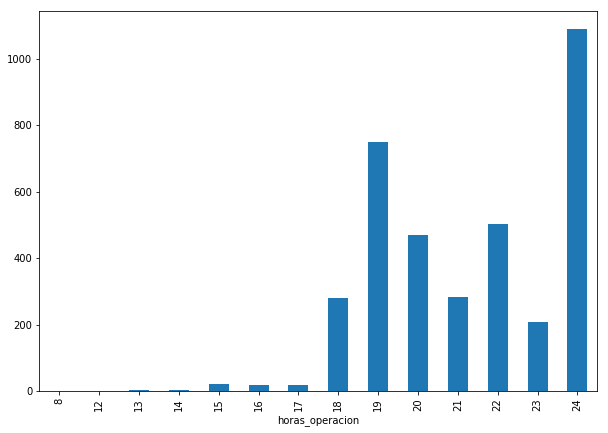

In [4]:
print("Distribución de los valores en columna horas operacion:")
data.groupby('horas_operacion')['horas_operacion'].count().plot(kind = "bar", figsize = (10, 7))

Consulta a experto: Para el caso de una sola tienda, opera 24 o 19 horas diarias (durante el último año), según el día de la semana. Excepciones puede deberse a días especiales como feriados, o a años anteriores cuando tenian horarios distintos

Distribución de los valores en columna pos en uso:


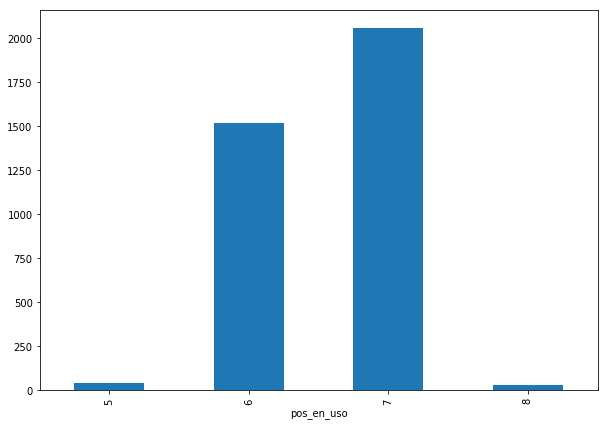

In [5]:
print("Distribución de los valores en columna pos en uso:")
data.groupby('pos_en_uso')['pos_en_uso'].count().plot(kind = "bar", figsize = (10, 7))

# Pre-Procesado

## 1. Convertir features de texto en numéricos (pero aún categóricos)

In [0]:
df = data.copy()  #Creamos una copia para mantener el DF original intacto
df['dia_de_la_semana'] = data['dia_de_la_semana'].replace(
    {'Lunes' : 0, 'Martes' : 1, 'Miercoles' : 2, 'Jueves' : 3, 'Viernes' : 4, 'Sabado' : 5, 'Domingo' : 6}
)
df['volumen'] = data['volumen'].replace({'alto' : 0, 'medio' : 1, 'bajo' : 2})
df['es_quincena'] = data['es_quincena'].replace({' VERDADERO ' : 1, ' FALSO ' : 0})

In [7]:
#Este caso especial primero cambiamos la palabra NO por un 0 y luego cambiamos cualquier otro valor por un 1
df['es_feriado'] = data['es_feriado'].replace({' NO ': 0})
df['es_feriado'] = df['es_feriado'].where(df['es_feriado'] == 0, other = 1)
df['es_feriado'].head(5)
print("Verificar resultado final:")
df.head(10)

Verificar resultado final:


,id_tienda,tipo_tienda,provincia,supervisor,mes_del_anio,semana_del_anio,es_quincena,es_feriado,dia_de_la_semana,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,volumen
0,xyz,FS,SAN JOSE,2015622_080,1,1,1,1,3,17,6,385,167,1
1,xyz,FS,SAN JOSE,2015622_080,1,1,1,0,4,19,7,400,147,1
2,xyz,FS,SAN JOSE,2015622_080,1,1,1,0,5,20,6,409,166,1
3,xyz,FS,SAN JOSE,2015622_080,1,2,0,0,6,19,6,455,185,1
4,xyz,FS,SAN JOSE,2015622_080,1,2,0,0,0,19,7,301,83,1
5,xyz,FS,SAN JOSE,2015622_080,1,2,0,0,1,18,7,307,94,1
6,xyz,FS,SAN JOSE,2015622_080,1,2,0,0,2,19,7,305,95,1
7,xyz,FS,SAN JOSE,2015622_080,1,2,0,0,3,19,7,288,75,2
8,xyz,FS,SAN JOSE,2015622_080,1,2,0,0,4,20,6,372,98,1
9,xyz,FS,SAN JOSE,2015622_080,1,2,0,0,5,19,6,446,189,1


## 2. Eliminar outliers

Las variables que nos interesan son las de cantidad de clientes, comparamos clientes totales vs. VIP para cada día y decidimos borrar aquellos valores que exceden la norma, que dentro del conjunto de datos no iban a aportar mayor detalle.

Tamaño original: (3650, 14)
Tamaño después de borrado: (3637, 14)


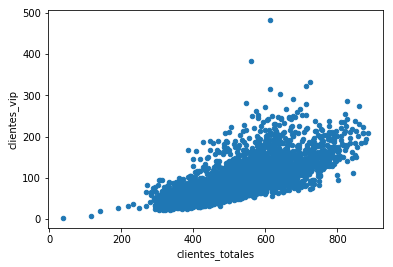

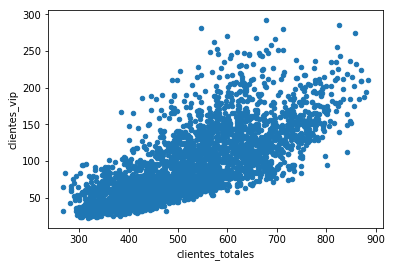

In [8]:
df.plot.scatter(x = 'clientes_totales', y = 'clientes_vip')
print("Tamaño original:", df.shape)

# para dataset de todas las sucursales:
#df1 = df[df.clientes_vip < 100]
#df1 = df1[df1.clientes_totales < 800]

# para dataset de una sucursal:
df1 = df[df.clientes_vip < 300]
df1 = df1[df1.clientes_totales > 250]

print("Tamaño después de borrado:", df1.shape)
df1.plot.scatter(x = 'clientes_totales', y = 'clientes_vip')

## 3. Convertir datos categóricos - One-hot encoding
Se determina que hay 3 features representativos, pero que tienen datos categóricos, incluyendo la salida/clases (mes_del_anio, dia_de_la_semana, volumen)

In [9]:
# One-hot encoding
df2 = pd.get_dummies(df1, columns=['mes_del_anio', 'dia_de_la_semana', 'volumen'])
df2.head()



,id_tienda,tipo_tienda,provincia,supervisor,semana_del_anio,es_quincena,es_feriado,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,mes_del_anio_1,mes_del_anio_2,mes_del_anio_3,mes_del_anio_4,mes_del_anio_5,mes_del_anio_6,mes_del_anio_7,mes_del_anio_8,mes_del_anio_9,mes_del_anio_10,mes_del_anio_11,mes_del_anio_12,dia_de_la_semana_0,dia_de_la_semana_1,dia_de_la_semana_2,dia_de_la_semana_3,dia_de_la_semana_4,dia_de_la_semana_5,dia_de_la_semana_6,volumen_0,volumen_1,volumen_2
0,xyz,FS,SAN JOSE,2015622_080,1,1,1,17,6,385,167,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,xyz,FS,SAN JOSE,2015622_080,1,1,0,19,7,400,147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,xyz,FS,SAN JOSE,2015622_080,1,1,0,20,6,409,166,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,xyz,FS,SAN JOSE,2015622_080,2,0,0,19,6,455,185,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,xyz,FS,SAN JOSE,2015622_080,2,0,0,19,7,301,83,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


## 4. Normalizar features horas_operacion y pos_en_uso
Se identifican 2 features que requieren ajustar sus escalas.
horas_operacion que están en el rango de 13 a 24
pos_en_uso entre 5 y 8

In [10]:
# Normalizando horas_operacion y pos_en_uso para el intervalo 0 a 1
df2["horas_operacion"] = df2["horas_operacion"]/24
df2["pos_en_uso"] = df2["pos_en_uso"]/8
df2.head(10)

,id_tienda,tipo_tienda,provincia,supervisor,semana_del_anio,es_quincena,es_feriado,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,mes_del_anio_1,mes_del_anio_2,mes_del_anio_3,mes_del_anio_4,mes_del_anio_5,mes_del_anio_6,mes_del_anio_7,mes_del_anio_8,mes_del_anio_9,mes_del_anio_10,mes_del_anio_11,mes_del_anio_12,dia_de_la_semana_0,dia_de_la_semana_1,dia_de_la_semana_2,dia_de_la_semana_3,dia_de_la_semana_4,dia_de_la_semana_5,dia_de_la_semana_6,volumen_0,volumen_1,volumen_2
0,xyz,FS,SAN JOSE,2015622_080,1,1,1,0.708333,0.750,385,167,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,xyz,FS,SAN JOSE,2015622_080,1,1,0,0.791667,0.875,400,147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,xyz,FS,SAN JOSE,2015622_080,1,1,0,0.833333,0.750,409,166,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,xyz,FS,SAN JOSE,2015622_080,2,0,0,0.791667,0.750,455,185,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,xyz,FS,SAN JOSE,2015622_080,2,0,0,0.791667,0.875,301,83,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
5,xyz,FS,SAN JOSE,2015622_080,2,0,0,0.750000,0.875,307,94,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
6,xyz,FS,SAN JOSE,2015622_080,2,0,0,0.791667,0.875,305,95,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
7,xyz,FS,SAN JOSE,2015622_080,2,0,0,0.791667,0.875,288,75,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
8,xyz,FS,SAN JOSE,2015622_080,2,0,0,0.833333,0.750,372,98,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
9,xyz,FS,SAN JOSE,2015622_080,2,0,0,0.791667,0.750,446,189,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


## 5. Borrar NaNs
Se consulta si hay NaNs, devolviendo un resultado negativo. El dataset no incluye valores NaN

In [11]:
print ("Shape antes: ", df2.shape)
print ("Hay Nans? ", df2.isnull().values.any())   #preguntar si hay NaN
# remove NaNs
df2 = df2.dropna()
print ("Shape después: ", df2.shape)

Shape antes:  (3637, 33)
Hay Nans?  False
Shape después:  (3637, 33)


## 6. Elección de columnas (features)

Para este corte se elimina todas las columnas que brindan info específica de tiendas pues solamente se analizará una tienda.

La columna semana del año y mes del año no brindan mayor información en conjunto, es posible que sean redundantes por lo que probaremos removiendo una de ellas.

In [12]:
cols_to_drop = ['id_tienda', 'tipo_tienda', 'provincia', 'supervisor', 'semana_del_anio', 'clientes_totales', 'clientes_vip']

clases = 3

processed = df2.drop(cols_to_drop, 1)
features_qty = processed.shape[1] - clases
print("Tamaño post-procesamiento:", processed.shape)
processed.head(5)

Tamaño post-procesamiento: (3637, 26)


,es_quincena,es_feriado,horas_operacion,pos_en_uso,mes_del_anio_1,mes_del_anio_2,mes_del_anio_3,mes_del_anio_4,mes_del_anio_5,mes_del_anio_6,mes_del_anio_7,mes_del_anio_8,mes_del_anio_9,mes_del_anio_10,mes_del_anio_11,mes_del_anio_12,dia_de_la_semana_0,dia_de_la_semana_1,dia_de_la_semana_2,dia_de_la_semana_3,dia_de_la_semana_4,dia_de_la_semana_5,dia_de_la_semana_6,volumen_0,volumen_1,volumen_2
0,1,1,0.708333,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,0,0.791667,0.875,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,1,0,0.833333,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,0,0.791667,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,0,0,0.791667,0.875,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


# Modelos de Clasificación
   ** Clasificador DecisionTree**

   ** Clasificador RandomForest**
   
   ** Clasificador Redes Neuronales ANN**

In [0]:
# Splitting the data input into X, and the labels y 
X = np.array(processed)[:,0:features_qty]
X = X.astype('float32')
y = keras.utils.to_categorical(df1["volumen"],clases)

Determinar cuáles columnas son features y cuáles labels.

En este caso las clases están dadas por "volumen" que indica si es un día alto volumen (cantidad de clientes), medio o bajo

In [14]:

# Splitting the data input into X, and the labels y 
features = np.array(processed)[:,0:features_qty]
features = features.astype('float32')
labels = keras.utils.to_categorical(df1["volumen"],clases)

print("Shape of features:", features.shape)
print("\nShape of labels:", labels.shape)
print("\nFirst 5 rows of features")
print(features[:5])
print("\nFirst 5 rows of labels")
print(labels[:5])



Shape of features: (3637, 23)

Shape of labels: (3637, 3)

First 5 rows of features
[[1.        1.        0.7083333 0.75      1.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.       ]
 [1.        0.        0.7916667 0.875     1.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        1.
  0.        0.       ]
 [1.        0.        0.8333333 0.75      1.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.       ]
 [0.        0.        0.7916667 0.75      1.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        1.       ]
 [0.        0.        0.7916667 0.875     1.

Separa set de entrenamiento y set de pruebas
Con una proporción 75% - 25%

In [15]:
X_train,X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state = 13) 

print ("shape del dataset completo: ", processed.shape)
print ("\nshape del set de entrenamiento: ", X_train.shape)
print ("\nshape del set de pruebas: ", y_test.shape)

shape del dataset completo:  (3637, 26)

shape del set de entrenamiento:  (2727, 23)

shape del set de pruebas:  (910, 3)


## Modelo clasificador usando DecisionTree

In [16]:
DecisionTreeModel = DecisionTreeClassifier(max_depth=3,min_samples_leaf=1)

#entrenamiento
print(DecisionTreeModel.fit(X_train, y_train))

#prediccion (usar datos de test)
y_predict = DecisionTreeModel.predict(X_test)

print("\nAccuracy para DecisionTree: {:.4f}".format(accuracy_score(y_test, y_predict)))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Accuracy para DecisionTree: 0.8736


## Modelo clasificador usando RandomForest

In [17]:
RandomForestModel = RandomForestClassifier(min_samples_leaf=5, min_samples_split=15, n_estimators=280, max_depth = 20, random_state = 10)

#entrenamiento
print(RandomForestModel.fit(X_train, y_train))

#prediccion (usar datos de test)
y_predict = RandomForestModel.predict(X_test)

print("\nAccuracy para Random Forest:     {:.4f}".format(accuracy_score(y_test, y_predict)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=280,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

Accuracy para Random Forest:     0.8791


## Modelo clasificador usando ANN

In [18]:


# Building the model


model = Sequential()

#capas intermedias
model.add(Dense(256, input_dim=features_qty))
model.add(Activation('tanh'))
model.add(Dropout(.2)) # now using dropout

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(.1)) # now using dropout

#capa de salida
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.summary()

# Training the model

epochs = 500
batch_size = 200

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train)
print("\n Training Accuracy:", score[1])
score = model.evaluate(X_test, y_test)
print("\n Testing Accuracy:", score[1])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               6144      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         

Conclusión: como era de esperar, según la complejidad de los algoritmos, cada uno iba mejorando el resultado (testing accuracy) del anterior: ANN > RandomForest > DecisionTree

Para llegar a estos resultados, probamos distintas combinaciones de hiperparámetros, siguiendo una secuencia de obtener el mejor resutado posible con el primer hiperparámetro y dejarlo fijo para los siguientes, y así sucesivamente hasta encontrar el mejor valor candidato para cada hiperparametro

El mejor accuracy en testing se obtuvo con un modelo de ANN y fue  88.24% sin overfitting
    

# Modelo de Regresión
El propósito de este modelo es tratar de proyectar las ventas a futuro lo más preciso posible.

El modelo de clasificación intentaba determina las ventas según 3 variables categóricas, probaremos con regresiones lineales para obtener estimaciones de clientes.

In [19]:
#Revisando el estado del data set actual
print(processed.shape)
processed.head(5)

(3637, 26)


,es_quincena,es_feriado,horas_operacion,pos_en_uso,mes_del_anio_1,mes_del_anio_2,mes_del_anio_3,mes_del_anio_4,mes_del_anio_5,mes_del_anio_6,mes_del_anio_7,mes_del_anio_8,mes_del_anio_9,mes_del_anio_10,mes_del_anio_11,mes_del_anio_12,dia_de_la_semana_0,dia_de_la_semana_1,dia_de_la_semana_2,dia_de_la_semana_3,dia_de_la_semana_4,dia_de_la_semana_5,dia_de_la_semana_6,volumen_0,volumen_1,volumen_2
0,1,1,0.708333,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,0,0.791667,0.875,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,1,0,0.833333,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,0,0.791667,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,0,0,0.791667,0.875,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [20]:
#Definiendo DF de atributos
cols_to_drop = ['volumen_0', 'volumen_1', 'volumen_2']
XLR = processed.drop(cols_to_drop, 1)
print(XLR.shape)
XLR.head(5)

(3637, 23)


,es_quincena,es_feriado,horas_operacion,pos_en_uso,mes_del_anio_1,mes_del_anio_2,mes_del_anio_3,mes_del_anio_4,mes_del_anio_5,mes_del_anio_6,mes_del_anio_7,mes_del_anio_8,mes_del_anio_9,mes_del_anio_10,mes_del_anio_11,mes_del_anio_12,dia_de_la_semana_0,dia_de_la_semana_1,dia_de_la_semana_2,dia_de_la_semana_3,dia_de_la_semana_4,dia_de_la_semana_5,dia_de_la_semana_6
0,1,1,0.708333,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0.791667,0.875,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0.833333,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0.791667,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.791667,0.875,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [21]:
#Definiendo DF de etiquetas
cols_to_select = ['clientes_totales', 'clientes_vip']
yLR = df2[cols_to_select]
print(yLR.shape)
yLR.head(5)

(3637, 2)


,clientes_totales,clientes_vip
0,385,167
1,400,147
2,409,166
3,455,185
4,301,83


In [22]:
#Obteniendo los DF de pruebas y validación a un rate de 80-20
XLR_train, XLR_test, yLR_train, yLR_test = train_test_split(XLR, yLR, random_state = 7, train_size = 0.8)
print(XLR_train.shape)
print(XLR_test.shape)


(2909, 23)
(728, 23)


Ahora procedemos a entrenar el modelo utilizando las 23 variables de entrada, junto con 1 capa oculta y una de salida usando la función de activación lineal.
Para esta prueba se utilizan 3 data sets: entrenamiento, validación y pruebas.
Las pruebas corresponden al 20% del total.
Validación corresponde al 20% del 80% restante.

**En este modelo se incluirán los días feriados.**

In [23]:
model = Sequential()
model.add(Dense(256, input_dim=23, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(.1))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(.1))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(.1))
model.add(Dense(2, activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               6144      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 6,658
Trainable params: 6,658
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])
history = model.fit(
    XLR_train, 
    yLR_train, 
    epochs = 500, 
    batch_size = 100, 
    verbose = 1, 
    validation_split = 0.2
)

Train on 2327 samples, validate on 582 samples
Epoch 1/500
2327/2327 [==============================] - 0s 135us/step - loss: 142910.7917 - mean_squared_error: 142910.7917 - mean_absolute_error: 299.3015 - val_loss: 141795.6700 - val_mean_squared_error: 141795.6700 - val_mean_absolute_error: 298.3485
Epoch 2/500
2327/2327 [==============================] - 0s 43us/step - loss: 141800.8392 - mean_squared_error: 141800.8392 - mean_absolute_error: 297.8527 - val_loss: 140248.1375 - val_mean_squared_error: 140248.1375 - val_mean_absolute_error: 296.2155
Epoch 3/500
2327/2327 [==============================] - 0s 51us/step - loss: 139774.0662 - mean_squared_error: 139774.0662 - mean_absolute_error: 294.9457 - val_loss: 137671.5718 - val_mean_squared_error: 137671.5718 - val_mean_absolute_error: 292.3847
Epoch 4/500
2327/2327 [==============================] - 0s 50us/step - loss: 136706.4729 - mean_squared_error: 136706.4729 - mean_absolute_error: 290.2384 - val_loss: 134032.4651 - val_mean

El final del último epoch obtenemos el MSE y el MAE que nos indican la escala del error que estamos obteniendo, un MSE y MAE inferiores serían idóneos siempre y cuando los valores se mantengan similares tanto en trainin como validación.

A continuación graficamos el modelo de pérdidas por cada epoch recorrida y obtenemos una varianza promedio haciendo las predicciones para el DF de pruebas y comparando resultados.

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


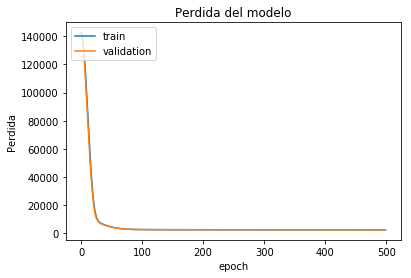

Variance score: 0.71


In [25]:
#Verificamos la perdida
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdida del modelo')
plt.ylabel('Perdida')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
yLR_pred = model.predict(XLR_test)
print('Variance score: %.2f' % r2_score(yLR_test, yLR_pred))

Ahora comparamos los resultados de la ANN con un modelo de regresión sencillo utilizando scikit learn, el modelo que obtenga un MSE inferior junto con una varianza superior será más efectivo.

In [26]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(XLR_train, yLR_train)

# Make predictions using the testing set
yLR_pred = regr.predict(XLR_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(yLR_test, yLR_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(yLR_test, yLR_pred))

Mean squared error: 2321.99
Variance score: 0.70


**Ahora procedemos con un nuevo modelo donde se excluyen los fías feriados como posibles outliers**

In [27]:
df_sin_feriados = df2[df2['es_feriado'] == 0].drop(['es_feriado'], 1)
print(df_sin_feriados.shape)
XLR_sin_feriados = df_sin_feriados.drop(['id_tienda', 'tipo_tienda', 'provincia', 'supervisor', 'semana_del_anio', 'clientes_totales', 'clientes_vip', 'volumen_0', 'volumen_1', 'volumen_2'], 1)
print(XLR_sin_feriados.shape)
XLR_sin_feriados.head(5)


(3508, 32)
(3508, 22)


,es_quincena,horas_operacion,pos_en_uso,mes_del_anio_1,mes_del_anio_2,mes_del_anio_3,mes_del_anio_4,mes_del_anio_5,mes_del_anio_6,mes_del_anio_7,mes_del_anio_8,mes_del_anio_9,mes_del_anio_10,mes_del_anio_11,mes_del_anio_12,dia_de_la_semana_0,dia_de_la_semana_1,dia_de_la_semana_2,dia_de_la_semana_3,dia_de_la_semana_4,dia_de_la_semana_5,dia_de_la_semana_6
1,1,0.791667,0.875,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0.833333,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0.791667,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0.791667,0.875,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0.750000,0.875,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [28]:
yLR_sin_feriados = df_sin_feriados[['clientes_totales', 'clientes_vip']]
print(yLR_sin_feriados.shape)
yLR_sin_feriados.head(5)

(3508, 2)


,clientes_totales,clientes_vip
1,400,147
2,409,166
3,455,185
4,301,83
5,307,94


In [29]:
XLR_train_sin_feriados, XLR_test_sin_feriados, yLR_train_sin_feriados, yLR_test_sin_feriados = train_test_split(XLR_sin_feriados, yLR_sin_feriados, random_state = 7, train_size = 0.8)

model = Sequential()
model.add(Dense(256, input_dim=22, kernel_initializer='normal', activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

history = model.fit(
    XLR_train_sin_feriados, 
    yLR_train_sin_feriados, 
    epochs = 500, 
    batch_size = 100, 
    verbose = 1, 
    validation_split = 0.2
)

yLR_pred_sin_feriados = model.predict(XLR_test_sin_feriados)
print('Variance score: %.2f' % r2_score(yLR_test_sin_feriados, yLR_pred_sin_feriados))

Train on 2244 samples, validate on 562 samples
Epoch 1/500
2244/2244 [==============================] - 0s 150us/step - loss: 140744.7738 - mean_squared_error: 140744.7738 - mean_absolute_error: 296.5570 - val_loss: 142085.8949 - val_mean_squared_error: 142085.8949 - val_mean_absolute_error: 297.6816
Epoch 2/500
2244/2244 [==============================] - 0s 49us/step - loss: 139698.5981 - mean_squared_error: 139698.5981 - mean_absolute_error: 295.1498 - val_loss: 140616.3753 - val_mean_squared_error: 140616.3753 - val_mean_absolute_error: 295.6095
Epoch 3/500
2244/2244 [==============================] - 0s 42us/step - loss: 137779.9200 - mean_squared_error: 137779.9200 - mean_absolute_error: 292.3232 - val_loss: 138121.6118 - val_mean_squared_error: 138121.6118 - val_mean_absolute_error: 291.8308
Epoch 4/500
2244/2244 [==============================] - 0s 47us/step - loss: 134811.3877 - mean_squared_error: 134811.3877 - mean_absolute_error: 287.6911 - val_loss: 134532.6763 - val_mean

In [30]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(XLR_train_sin_feriados, yLR_train_sin_feriados)

# Make predictions using the testing set
yLR_pred_sin_feriados = regr.predict(XLR_test_sin_feriados)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(yLR_test_sin_feriados, yLR_pred_sin_feriados))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(yLR_test_sin_feriados, yLR_pred_sin_feriados))

Mean squared error: 2268.90
Variance score: 0.73


## Resultados regresión lineal
Probamos 4 modelos:
- ANN lineal con días feriados
- ML Lineal con días feriados
- ANN lineal sin feriados
- ML Lineal sin feriados

Los resultados de ambas ANN fueron practicamente los mismos, siguen siendo apenas mejores que una ML convencional.
Mientras que la ML al excluir feriados de hecho logró superar en un punto el porcentaje de precisión de la ANN.

Hicimos la prueba de eliminar feriados con tal de reducir el efecto de posibles outliers más realmente no probó ser muy eficaz.

Las ANN se probaron de diferentes maneras, fuera agregando más capas, más neuronas, más epochs, con menos métricas de error (ej. usando solo MSE o solo MAE, pero la combinación de ambos es más efectiva.

El modelo de regresión es menos eficiente que el modelo de clasificación seguramente porque le resulta más sencillo a los algoritmos trabajar clasificando rangos más amplios, a la hora de precisar un número obtener un resultado exacto es considerablemente más complicado pero se esperaría obtener un margen de error no muy bajo.

En este caso buscamos minimizar el MSE junto con el MAE para obtener la media de error más baja, lo que nos lleva a una varianza promedio (r2_score) de 0.72 en el mejor de los casos.

El resultado no es el mejor esperado pero es una buena prueba de precisión, en todo caso como mencionábamos en el contexto, a la tienda le interesa más poder clasificar los días según las 3 bandas por cantidad de clientes, y bajo ese modelo los resultados son bastante más exitosos.



## Resumen de resultados y conclusiones finales:
### Modelos clasificadores: entre 87% y 88%
### Modelos regresores: entre 70% y 73%

En el contexto del negocio, y con el conocimiento del criterio experto, los modelos obtenidos para clasificación son aceptables y funcionales para usar las predicciones como entrada de los sistemas de Horarios y Pedidos.

Una recomendación de mejora para estudios futuros sería disponer de más datos, eventualmente no solo por día, sino por rango horario (mañana, tarde, noche) o por otro criterio que el cliente pudiera tener; o más años, aunque no estamos seguros si más de 10 años de antiguedad en el negocio del contexto sea relevante o aporte a estos modelos.